<a href="https://colab.research.google.com/github/glazar01/lyric-pulse-sentiment-analysis/blob/main/models/lyrics_analysis_all_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lyric Pulse: Evaluating Emotion Recognition Models on Song Lyrics

This markdown test four different models on some song lyrics.

### Libraries

In [1]:
!pip install --no-cache-dir transformers sentencepiece

In [2]:
!pip3 install torch

In [3]:
# import libraries
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import spacy
import torch
import tensorflow as tf

# Import Data

More analysis for the data can be found in the data_analysis notebook in the github repository.

## Single Label

In [196]:
s_url = "https://raw.githubusercontent.com/glazar01/lyric-pulse-sentiment-analysis/main/data/SingleLabel.csv"
s_data = pd.read_csv(s_url)

In [5]:
s_data.head()

,artist,genre,title,album,year,lyrics,label
0,Nirvana,Rock,You Know You’re Right,Nirvana,2002.0,I will never bother you\nI will never promise ...,Sadness
1,Damian Marley,Reggae,Here We Go,Stony Hill,2017.0,Here we go\nMy big ego is gonna get me in trou...,Tension
2,The Mission UK,Rock,Jade,Another Fall from Grace,2016.0,She came as Lolita dressed as Venus\nAnd adorn...,Tenderness
3,UB40,Reggae,Food For Thought,Signing Off,1980.0,"Ivory Madonna, dying in the dust\nWaiting for ...",Sadness
4,Johnny Cash,Country,I’ve Been Everywhere,American II: Unchained,1996.0,I was totin' my pack along the dusty Winnemucc...,Sadness


In [240]:
single_label_emotions = ['Tenderness', 'Tension','Sadness']

## Multi Label

In [6]:
m_url = "https://raw.githubusercontent.com/glazar01/lyric-pulse-sentiment-analysis/main/data/MultiLabel.csv"
m_data = pd.read_csv(m_url)

In [7]:
m_data.head()

,artist,genre,title,album,year,lyrics,labels
0,Nirvana,Rock,You Know You’re Right,Nirvana,2002.0,I will never bother you\nI will never promise ...,"Calmness, Sadness"
1,Damian Marley,Reggae,Here We Go,Stony Hill,2017.0,Here we go\nMy big ego is gonna get me in trou...,"Power, Tension"
2,The Mission UK,Rock,Jade,Another Fall from Grace,2016.0,She came as Lolita dressed as Venus\nAnd adorn...,"Amazement, Calmness, Solemnity, Tenderness"
3,UB40,Reggae,Food For Thought,Signing Off,1980.0,"Ivory Madonna, dying in the dust\nWaiting for ...","Joyful activation, Sadness, Tension"
4,Johnny Cash,Country,I’ve Been Everywhere,American II: Unchained,1996.0,I was totin' my pack along the dusty Winnemucc...,"Amazement, Calmness, Joyful activation"


In [241]:
multi_label_emotions = ['Amazement', 'Calmness', 'Joyful activation', 'Nostalgia', 'Power', 'Sadness', 'Solemnity', 'Tenderness', 'Tension']

# Useful Functions

1. Sentence segmentation

In [33]:
''' Segmentation in sentences for lyrics, removal of empty or duplicated sentences '''
def process_lyrics(text_data):
    def process_text(text):
        unique_sentences = set()
        processed_text = []

        for sentence in text.split('\n'):
            sentence_text = sentence.strip()
            if sentence_text and sentence_text not in unique_sentences:
                unique_sentences.add(sentence_text)
                processed_text.append(sentence_text)

        return processed_text

    processed_data = [process_text(row) for row in text_data]
    return processed_data

In [44]:
# Before sentence segmentation
s_data['lyrics'][0]

"I will never bother you\nI will never promise to\nI will never follow you\nI will never bother you\nNever speak a word again\nI will crawl away for good\nI will move away from here\nYou won't be afraid of fear\nNo thought was put into this\nAnd always knew it would come to this\nThings have never been so swell\nI have never failed to fail\n\nHe-eee-eee-eeey\nHe-eee-eee-eey\nHe-eee-eee-ey\nYou know you're right\nYou know you're right\nYou know you're right\n\nI'm so warm and calm inside\nI no longer have to hide\nLet's talk about someone else\nSteaming soup against her mouth\nNothing really bothers her\nShe just wants to love himself\nI will move away from here\nYou won't be afraid of fear\nNo thought was put into this\nAlways knew it'd come to this\nThings have never been so swell\nI have never failed to fail\n\nHe-eee-eee-eey\nHe-eee-eee-eey\nHe-eee-eee-eey\nHe-eee-eee-eey\nHe-eee-eee-eey\nYou know you're right\nYou know you're right\nYou know you're right\nYou know you're right\nYou

In [41]:
processed_lyrics = process_lyrics(s_data['lyrics'])

In [42]:
# After sentence segmentation
processed_lyrics[0]

['I will never bother you',
 'I will never promise to',
 'I will never follow you',
 'Never speak a word again',
 'I will crawl away for good',
 'I will move away from here',
 "You won't be afraid of fear",
 'No thought was put into this',
 'And always knew it would come to this',
 'Things have never been so swell',
 'I have never failed to fail',
 'He-eee-eee-eeey',
 'He-eee-eee-eey',
 'He-eee-eee-ey',
 "You know you're right",
 "I'm so warm and calm inside",
 'I no longer have to hide',
 "Let's talk about someone else",
 'Steaming soup against her mouth',
 'Nothing really bothers her',
 'She just wants to love himself',
 "Always knew it'd come to this",
 '(He-eee-eee-eey)',
 'You know your rights']

2. Run the model and get sentiment scores (apply to models 1-3)

In [112]:
''' Runs the model (applying to models 1-3) on given lyrics and model's emotions and returns the sentiment scores'''
def get_sentiment_scores_by_sentences(lyrics, model, model_emotions):
    aggregated_scores = dict.fromkeys(model_emotions, 0)
    num_sentences = len(lyrics)

    # Process sentences in batches
    for i in range(num_sentences):
        sentence = lyrics[i]
        results_sentence = model(sentence)

        for result in results_sentence:
          for res in result:
            label = res['label']
            score = res['score']
            aggregated_scores[label] += score

    # Average the scores
    for label in aggregated_scores:
        aggregated_scores[label] /= num_sentences

    return aggregated_scores

In [ ]:
''' Function to run the model 4'''
def get_emotion(text, model):
  input_ids = tokenizer.encode(text + '</s>', return_tensors='pt')

  output = model.generate(input_ids=input_ids,
               max_length=2)

  dec = [tokenizer.decode(ids) for ids in output]
  label = dec[0]
  return label

4. Find the emotion with the maximum score

In [47]:
def find_max_key(sentiment_scores, ignore_key='neutral'):
    second_max_keys = []
    for lyric_sentiment_scores in sentiment_scores:
        sorted_keys = sorted(lyric_sentiment_scores, key=lambda x: lyric_sentiment_scores[x], reverse=True)
        if sorted_keys[0] == ignore_key:
            # If the first key is 'Neutral' we consider the second key
            second_max_keys.append(sorted_keys[1])
        else:
            second_max_keys.append(sorted_keys[0])
    return second_max_keys

5. Calculate the accuracy of the model

In [156]:
''' Calculate the accuracy of a model. If singleLabel is true then we use the single label data set, otherwise the multi label.'''
def calculate_accuracy(original_emotions, predicted_emotions, singleLabel=True):
  if singleLabel:
    correct_predictions = sum(original == predicted for original, predicted in zip(original_emotions, predicted_emotions))
  else:
    correct_predictions = sum(predicted in {word.strip() for word in original.split(',')} for original, predicted in zip(original_emotions, predicted_emotions))
  return correct_predictions/len(original_emotions)

# Models

In [ ]:
from transformers import pipeline

In [115]:
models = []

In [53]:
model_emotions = {}

In [59]:
sentiment_scores = {}

In [148]:
dominant_sentiments = {}

## Model 1:

In [116]:
models.append(pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None))

In [54]:
model_emotions[0] = ['love', 'admiration', 'approval', 'neutral', 'joy', 'optimism', 'gratitude', 'desire', 'annoyance', 'caring', 'disapproval', 'anger', 'realization', 'sadness', 'excitement', 'disappointment', 'amusement', 'confusion', 'disgust', 'curiosity', 'surprise', 'remorse', 'fear', 'nervousness', 'embarrassment', 'grief', 'pride', 'relief']

In [114]:
test_scores = get_sentiment_scores_by_sentences(processed_lyrics[0], models[0], model_emotions[0])
test_scores

{'love': 0.009968048295074064,
 'admiration': 0.013532166432317657,
 'approval': 0.08453840087167919,
 'neutral': 0.6173456426089009,
 'joy': 0.03887427455629222,
 'optimism': 0.03178784705232829,
 'gratitude': 0.0022090721528608506,
 'desire': 0.011329153622985663,
 'annoyance': 0.021234943269519135,
 'caring': 0.04287284387343485,
 'disapproval': 0.05202990907127969,
 'anger': 0.008183128569119921,
 'realization': 0.03795814326925514,
 'sadness': 0.009100369842296155,
 'excitement': 0.011620549544507716,
 'disappointment': 0.011168352837557904,
 'amusement': 0.004524723032470017,
 'confusion': 0.0027399567091682306,
 'disgust': 0.0024314690842099176,
 'curiosity': 0.002558888196896684,
 'surprise': 0.012454538523646383,
 'remorse': 0.0009703773527386753,
 'fear': 0.004743492247750207,
 'nervousness': 0.001677743804975762,
 'embarrassment': 0.0015005429074032388,
 'grief': 0.0009234571783357145,
 'pride': 0.0019465359170377876,
 'relief': 0.0056654434720257996}

## Model 2:

In [117]:
models.append(pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True))

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [89]:
test_scores = get_sentiment_scores_by_sentences(processed_lyrics[0], models[1], model_emotions[1])
test_scores

{'anger': 0.1198090743952586,
 'disgust': 0.11130956945028932,
 'fear': 0.0936418952672587,
 'joy': 0.14156872494398462,
 'neutral': 0.3558837102415661,
 'sadness': 0.1331049094927342,
 'surprise': 0.04468212039986005}

In [64]:
model_emotions[1] = ["anger","disgust","fear","joy","neutral","sadness","surprise"]

## Model 3:

In [118]:
models.append(pipeline("text-classification",model='bhadresh-savani/distilbert-base-uncased-emotion', return_all_scores=True))

In [93]:
model_emotions[2] = ['sadness','joy','love','anger','fear','surprise']

In [95]:
test_scores = get_sentiment_scores_by_sentences(processed_lyrics[0], models[2], model_emotions[2])
test_scores

{'sadness': 0.1231724840120781,
 'joy': 0.29729707747416495,
 'love': 0.005218274750707981,
 'anger': 0.47074906077493023,
 'fear': 0.10181797693924939,
 'surprise': 0.0017451177263865247}

## Run for models 1-3

In [141]:
for i in range(len(models)-1):
  sentiment_scores[i] = [get_sentiment_scores_by_sentences(lyrics, models[i], model_emotions[i]) for lyrics in processed_lyrics]

In [149]:
for i in range(len(sentiment_scores)):
  dominant_sentiments[i] = find_max_key(sentiment_scores[i], ignore_key='neutral')

## Model4: t-5 base-finetuned-emotion

For this model it is a little bit different, that's why we create a different function to handle it.

In [98]:
from transformers import AutoTokenizer, AutoModelWithLMHead
from nltk.tokenize import sent_tokenize

In [119]:
tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-emotion")
models.append(AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-emotion"))

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1499: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


In [ ]:
model_emotions[3] = ['sadness','joy','love','anger','fear','surprise']

In [130]:
from collections import Counter

def get_aggregated_emotion_for_lyrics(lyrics, model):
    emotions = [get_emotion(sentence, model) for sentence in lyrics]
    filtered_emotions = [sentence.replace('<pad> ', '') for sentence in emotions]
    most_common_emotion = Counter(filtered_emotions).most_common(1)[0][0]
    return most_common_emotion

In [131]:
get_aggregated_emotion_for_lyrics(processed_lyrics[0], models[3])

'anger'

In [151]:
dominant_sentiments[3] = [get_aggregated_emotion_for_lyrics(lyrics, models[3]) for lyrics in processed_lyrics]

Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors


# Model Evaluation

In [163]:
emotion_mappings = {
    'love' : {'Single': 'Tenderness','Multi' : 'Tenderness'},
    'admiration' : {'Single': 'Tenderness','Multi' : 'Amazement'},
    'approval' : {'Single': 'Tenderness','Multi' : 'Power'},
    'joy' : {'Single': 'Tenderness','Multi' : 'Joyful activation'},
    'optimism' : {'Single': 'Tenderness','Multi' : 'Joyful activation'},
    'gratitude' : {'Single': 'Tenderness','Multi' : 'Power'},
    'desire' : {'Single': '','Multi' : 'Nostalgia'},
    'annoyance' : {'Single': 'Tension','Multi' : 'Tension'},
    'caring' : {'Single': 'Tenderness','Multi' : 'Tenderness'},
    'disapproval' : {'Single': 'Tension','Multi' : 'Tension'},
    'anger' : {'Single': 'Tension','Multi' : 'Tension'},
    'realization' : {'Single': 'Tension','Multi' : 'Solemnity'},
    'sadness' : {'Single': 'Sadness','Multi' : 'Sadness'},
    'excitement' : {'Single': 'Tension','Multi' : 'Joyful activation'},
    'disappointment' : {'Single': 'Sadness', 'Multi' : 'Sadness'},
    'amusement' : {'Single': 'Tenderness','Multi' : 'Joyful activation'},
    'confusion' : {'Single': 'Tension','Multi' : 'Tension'},
    'disgust' : {'Single': 'Tension','Multi' : 'Tension'},
    'curiosity' : {'Single': 'Tension','Multi' : 'Tension'},
    'surprise' : {'Single': 'Tension','Multi' : 'Amazement'},
    'remorse' : {'Single': 'Sadness','Multi' : 'Sadness'},
    'fear' : {'Single': '','Multi' : 'Tension'},
    'nervousness' : {'Single': 'Tension','Multi' : 'Tension'},
    'embarrassment' : {'Single': 'Tension','Multi' : 'Tension'},
    'grief' : {'Single': 'Sadness','Multi' : 'Sadness'},
    'pride' : {'Single': 'Tenderness','Multi' : 'Joyful activation'},
    'relief' : {'Single': 'Tenderness','Multi' : 'Tenderness'}
}

In [157]:
s_mapped_predictions = {}
m_mapped_predictions = {}

In [167]:
s_accuracy = {}
m_accuracy = {}

## Single Label

In [159]:
s_original_emotions = s_data['label']

In [168]:
for i in range(len(models)):
  s_mapped_predictions[i] = [emotion_mappings[dominant]['Single'] for dominant in dominant_sentiments[i]]
  s_accuracy[i] = calculate_accuracy(s_original_emotions, s_mapped_predictions[i])

In [182]:
print("The accuracy of each model for the single-label data set\n")
for i in range(len(models)):
  print("Model",i+1,":",s_accuracy[i])

The accuracy of each model for the single-label data set

Model 1 : 0.45
Model 2 : 0.4267241379310345
Model 3 : 0.3758620689655172
Model 4 : 0.36982758620689654


## Multi Label

In [170]:
m_original_emotions = m_data['labels']

In [175]:
for i in range(len(models)):
  m_mapped_predictions[i] = [emotion_mappings[dominant]['Multi'] for dominant in dominant_sentiments[i]]
  m_accuracy[i] = calculate_accuracy(m_original_emotions, m_mapped_predictions[i],singleLabel=False)

In [183]:
print("The accuracy of each model for the multi-label data set\n")
for i in range(len(models)):
  print("Model",i+1,":",m_accuracy[i])

The accuracy of each model for the multi-label data set

Model 1 : 0.6120689655172413
Model 2 : 0.5793103448275863
Model 3 : 0.5232758620689655
Model 4 : 0.4939655172413793


# Modify data set to add the predicted values

In [197]:
for i in range(len(models)):
  name = 'm'+str(i+1)+'_label'
  s_data[name] = s_mapped_predictions[i]

In [199]:
for i in range(len(models)):
  name = 'm'+str(i+1)+'_label'
  m_data[name] = m_mapped_predictions[i]

# Visualizations

In [239]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

### 1. Emotion Distribution

In [307]:
def plot_emotion_distribution(data, model_num=0, singleLabel=True):
  sns.set_style("whitegrid")
  plt.figure(figsize=(10, 6))
  title = 'Distribution of '

  if singleLabel:
    x = 'label'
    order_tag = x
    plt.rcParams.update({'font.size': 20})
    plt.xticks(fontsize=16)
  else:
    x = 'labels'
    order_tag = 'm'+str(model_num)+'_label'
    plt.rcParams.update({'font.size': 12})
    plt.xticks(fontsize=8)
    all_emotions = [emotion.strip() for labels in data[x] for emotion in labels.split(',')]
    emotion_counts = pd.Series(all_emotions).value_counts()

  if model_num == 0:
    title += 'Original Emotions'
    if singleLabel:
      sns.countplot(data=data, x=x, order=data[x].value_counts().index)
    else:
      plt.bar(emotion_counts.index, emotion_counts.values)
  else:
    title += 'Predicted Emotions for Model ' + str(model_num)
    sns.countplot(data=data, x='m'+str(model_num)+'_label', order=data[order_tag].value_counts().index)

  plt.title(title)
  plt.ylabel('Count', fontsize=18)
  plt.xlabel('Emotion', fontsize=18)
  plt.show()

#### a. Single Label Dataset

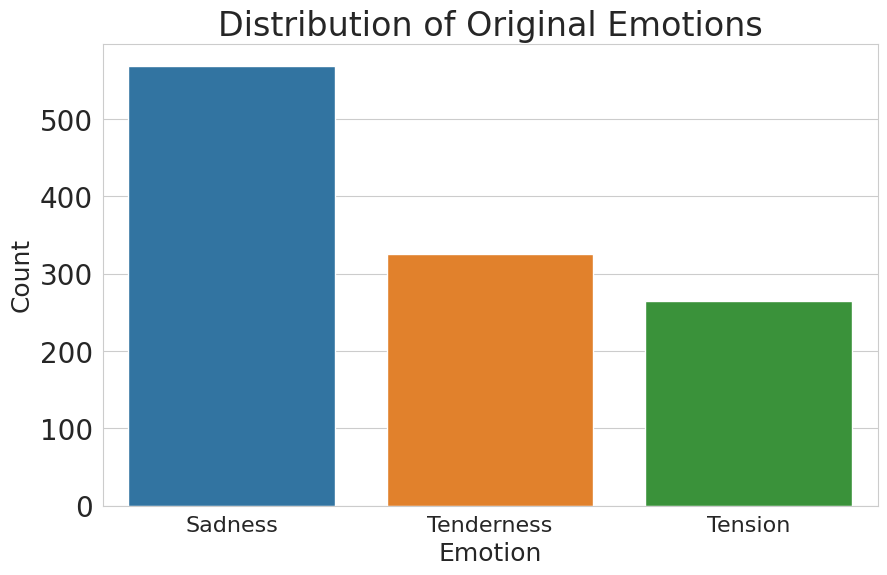

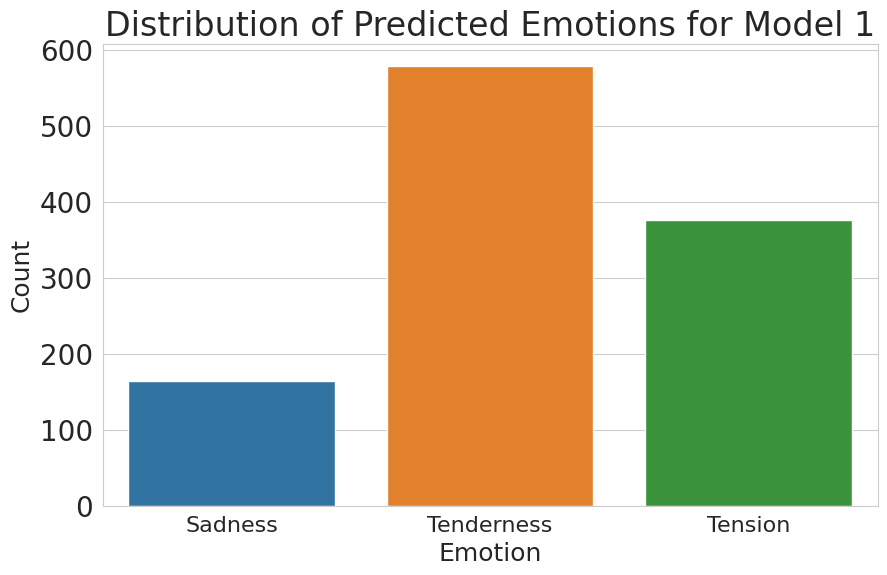

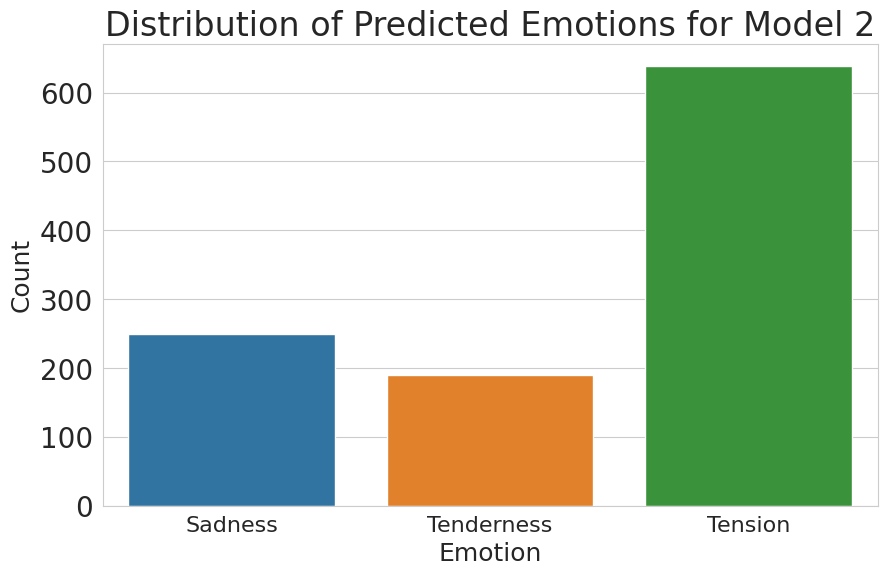

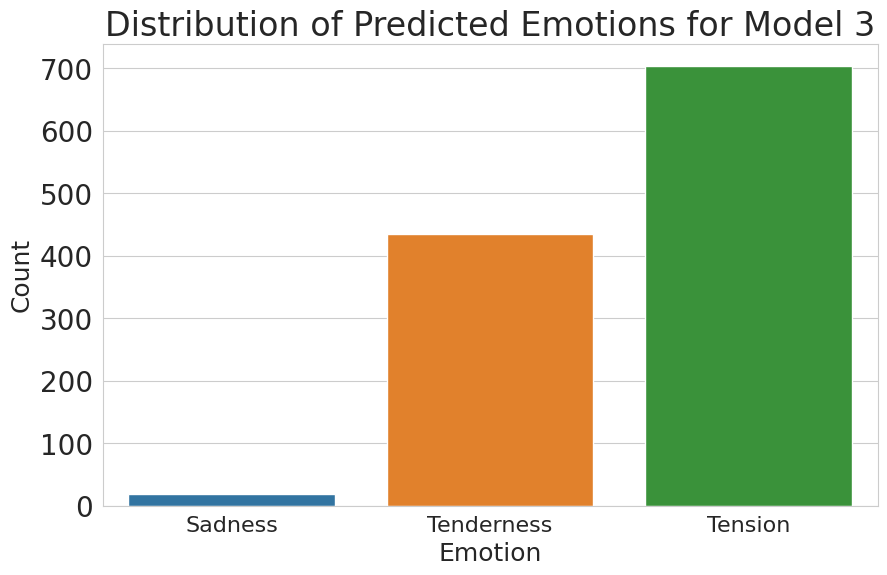

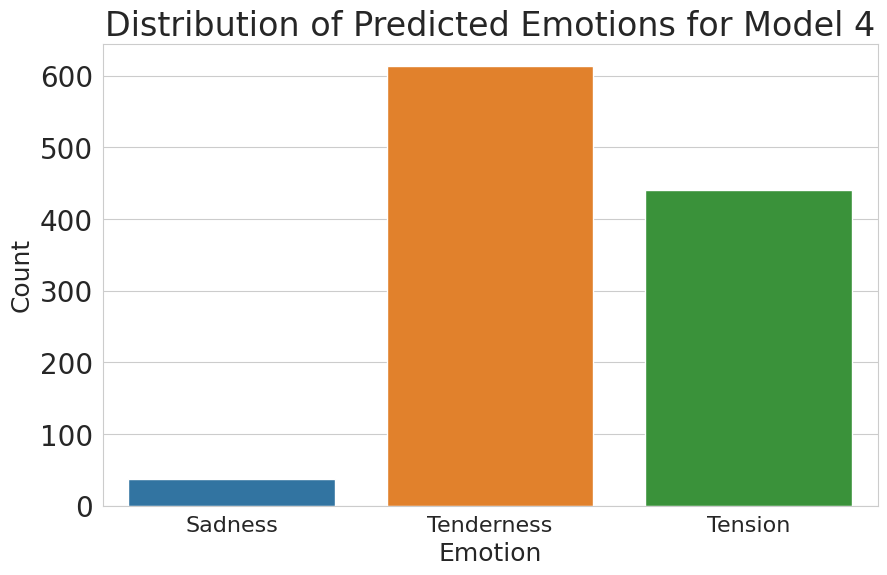

In [238]:
plot_emotion_distribution(s_data,0)
for i in range(len(models)):
  plot_emotion_distribution(s_data,i+1)

#### b. Multi Label Dataset

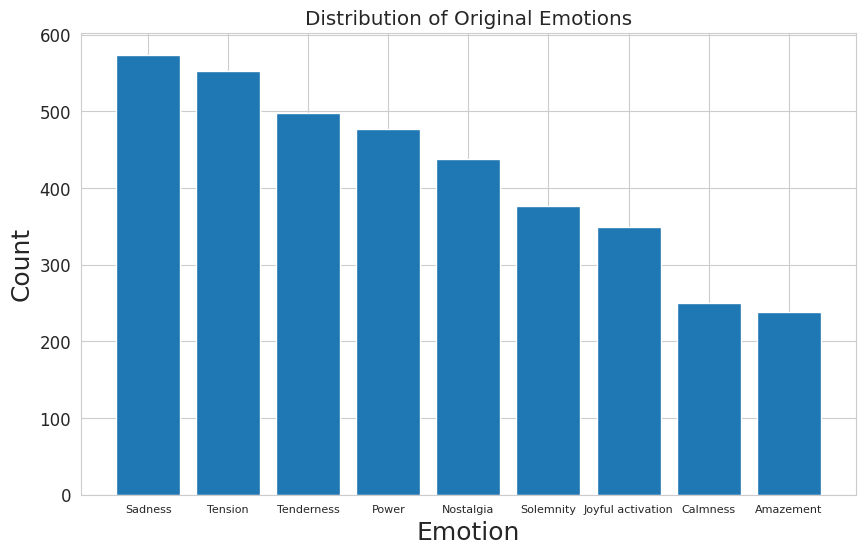

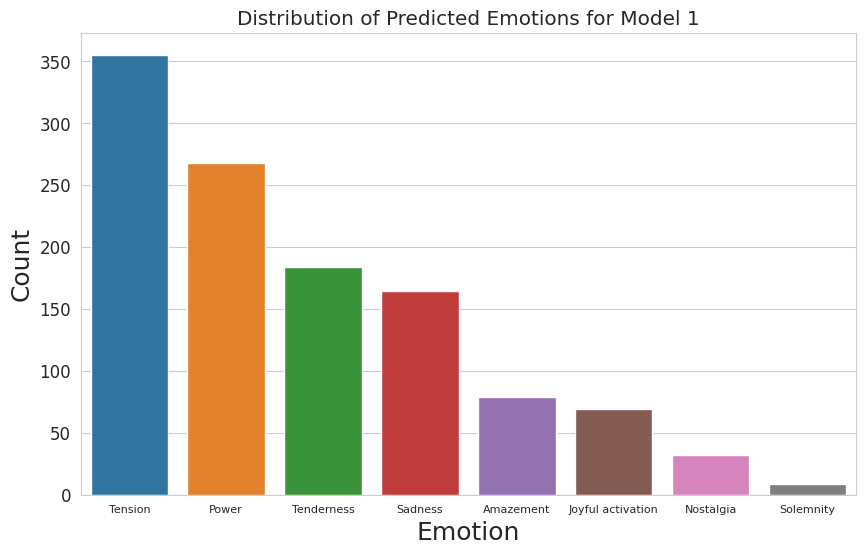

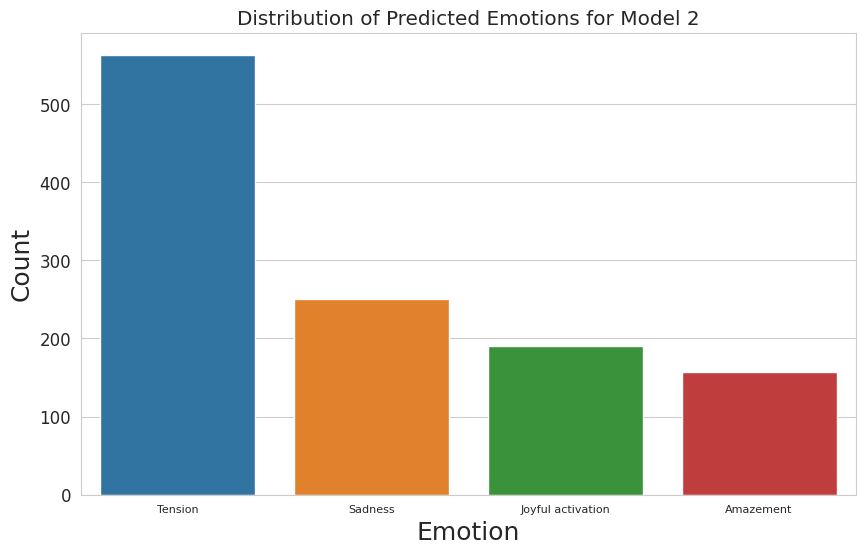

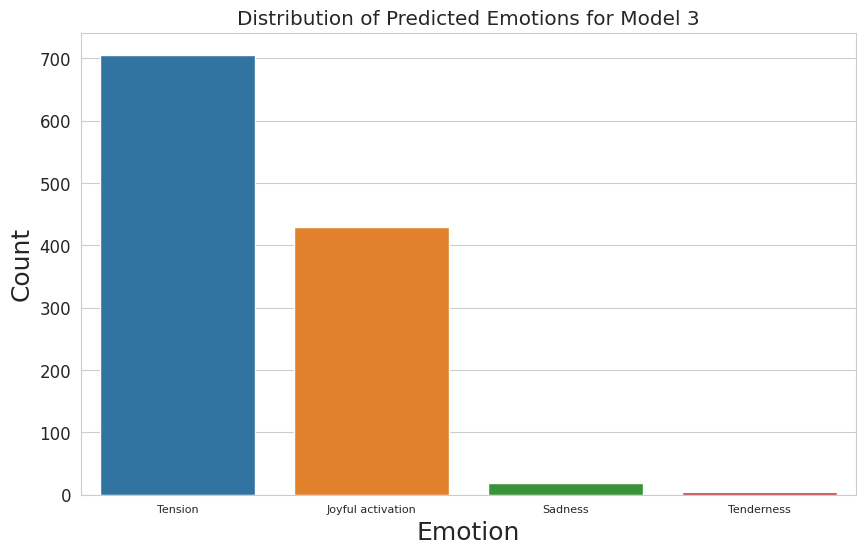

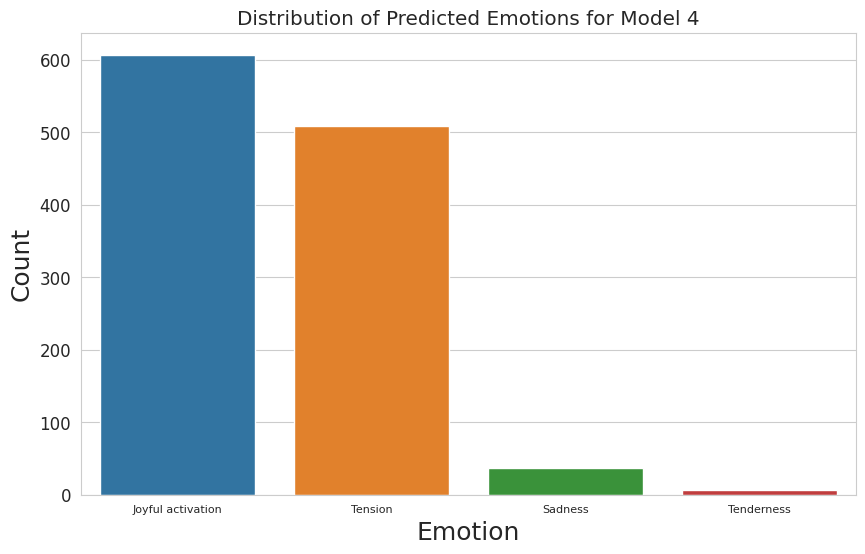

In [308]:
plot_emotion_distribution(m_data, 0, singleLabel=False)
for i in range(len(models)):
  plot_emotion_distribution(m_data,i+1, singleLabel=False)

### 2. Confusion Matrices for Single Label Data set

In [278]:
def calculate_confusion_matrix(original_emotions, predicted_emotions, labels):
  cm = confusion_matrix(original_emotions, predicted_emotions, labels=unique_labels)
  return cm

In [313]:
def plot_confusion_matrix(original_emotions, predicted_emotions, model_num):
  unique_labels = list(set(original_emotions) | set(predicted_emotions))
  while("" in unique_labels):
    unique_labels.remove("")

  cm = calculate_confusion_matrix(original_emotions, predicted_emotions, unique_labels)

  # Visualize the confusion matrix
  plt.figure(figsize=(12, 8))
  sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
  plt.title('Confusion Matrix for Model ' + str(model_num))
  plt.rcParams.update({'font.size': 25})
  plt.ylabel('True Labels')
  plt.xlabel('Predicted Labels')
  plt.show()

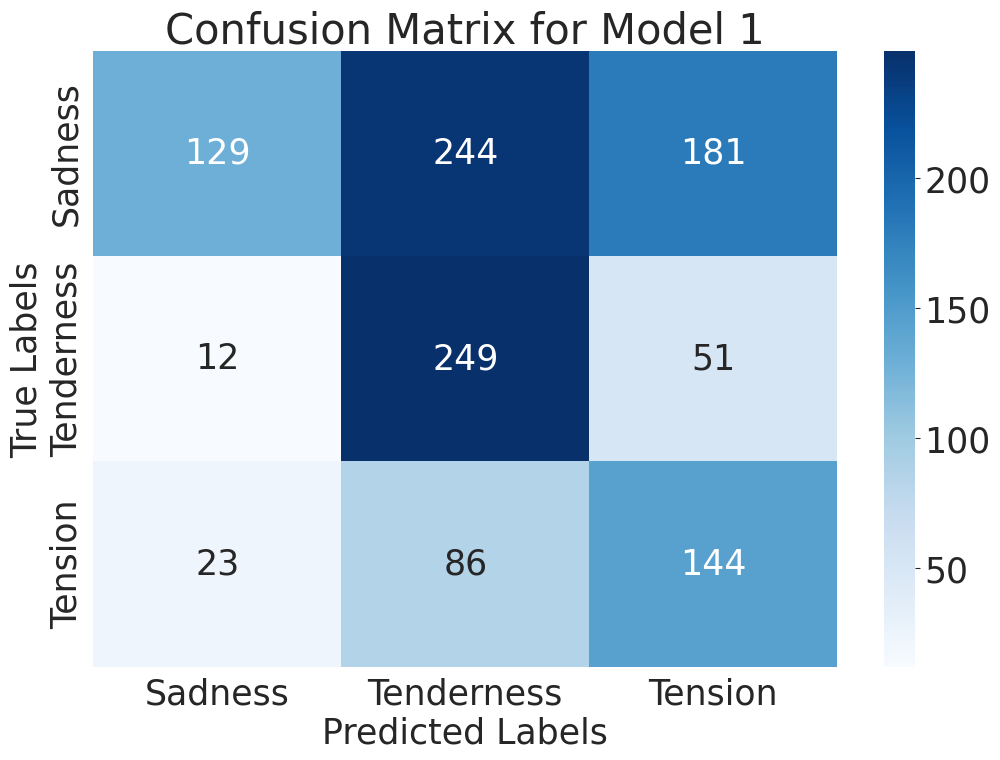

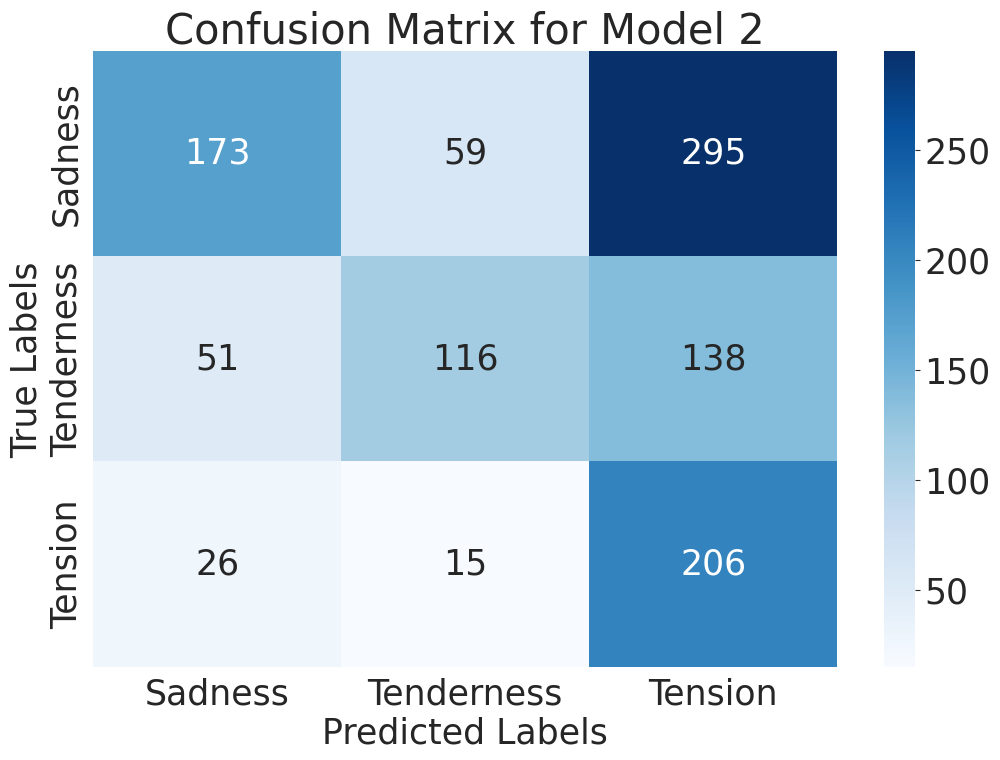

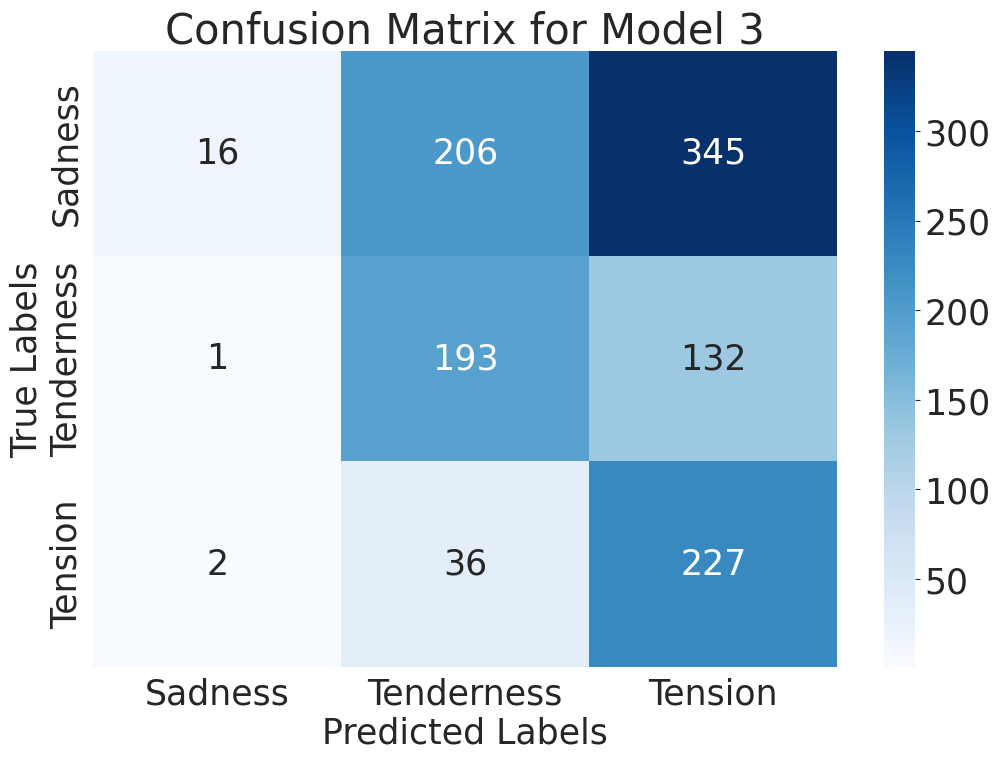

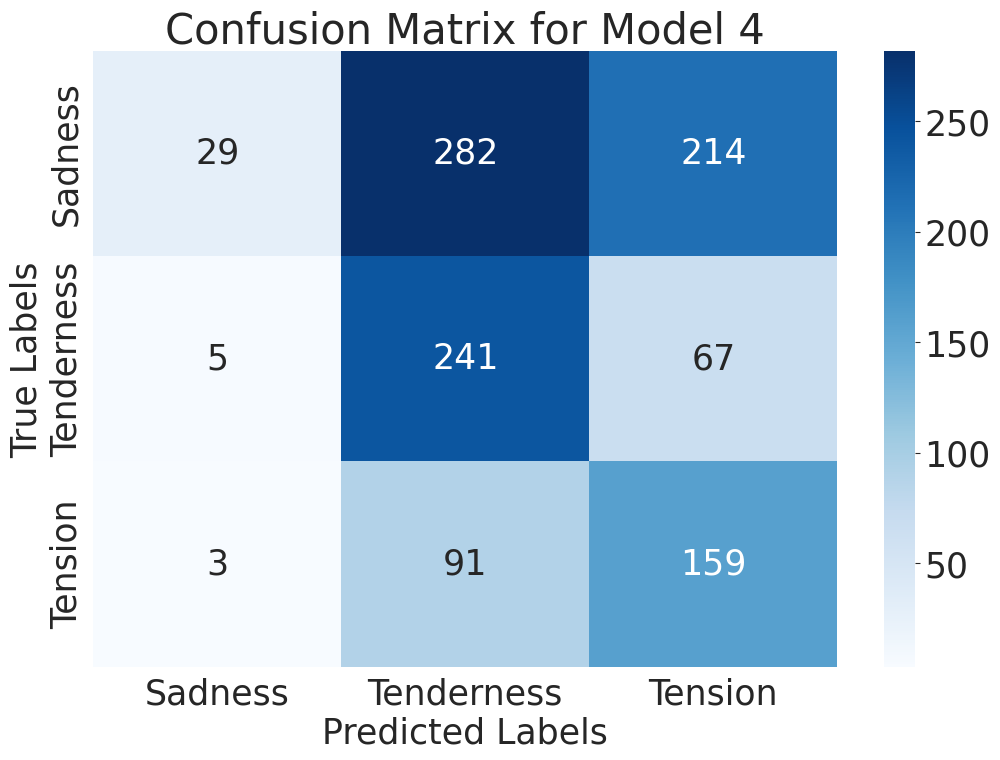

In [273]:
for i in range(len(models)):
  plot_confusion_matrix(s_original_emotions, s_mapped_predictions[i], i+1)

### 3. Accuracy for each emotion

In [425]:
def plot_accuracy(original_emotions, predicted_emotions, model_num):
  unique_labels = list(set(original_emotions) | set(predicted_emotions))
  unique_labels.remove("")

  cm = calculate_confusion_matrix(original_emotions, predicted_emotions, unique_labels)

  accuracies = cm.diagonal() / cm.sum(axis=1)

  # Mapping of emotions to their accuracies
  emotion_accuracy = dict(zip(unique_labels, accuracies))

  # Visualize the accuracies
  plt.figure(figsize=(10, 6))
  sns.barplot(x=list(emotion_accuracy.keys()), y=list(emotion_accuracy.values()), palette="viridis")
  plt.rcParams.update({'font.size': 20})
  plt.title('Prediction Accuracy per Emotion for Model ' + str(model_num))
  plt.ylabel('Accuracy')
  plt.xlabel('Emotion')
  plt.ylim(0, 1)  # Setting y-axis limits to be between 0 and 1 for clarity
  plt.show()

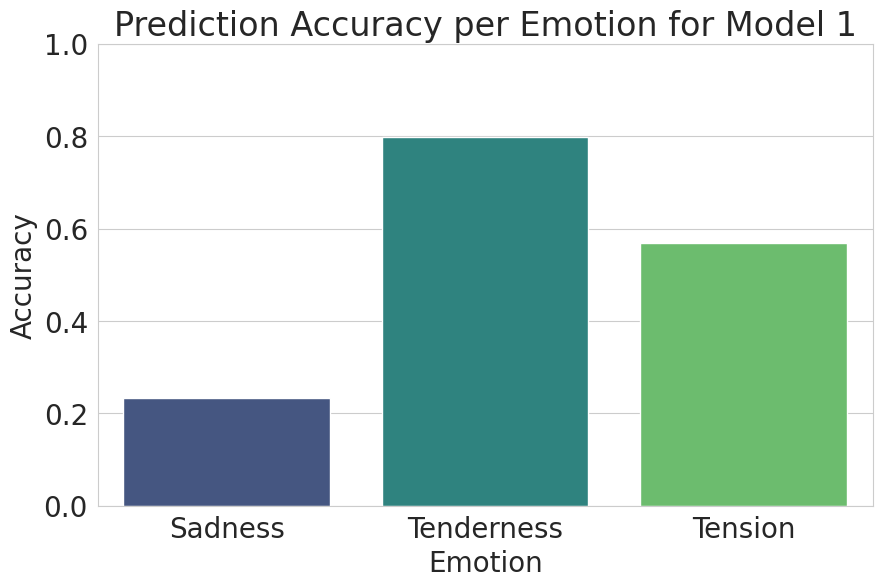

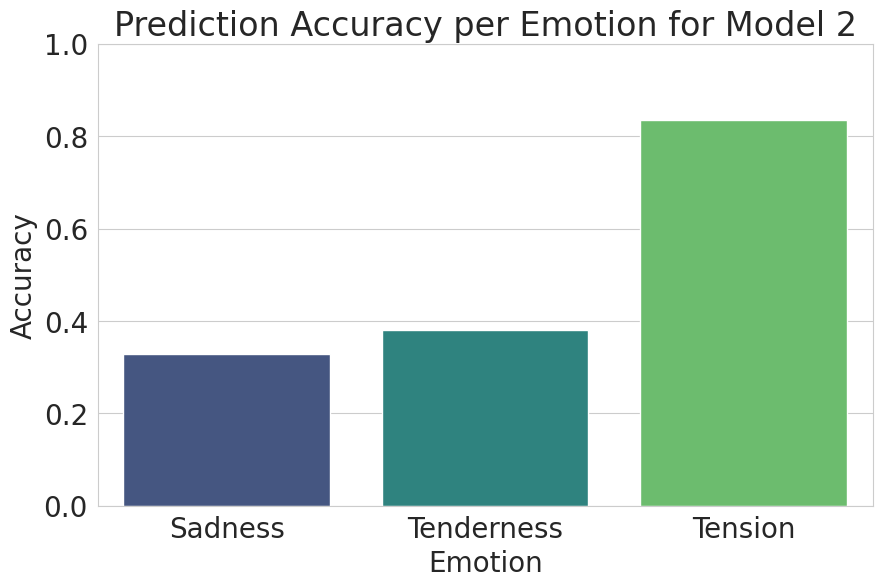

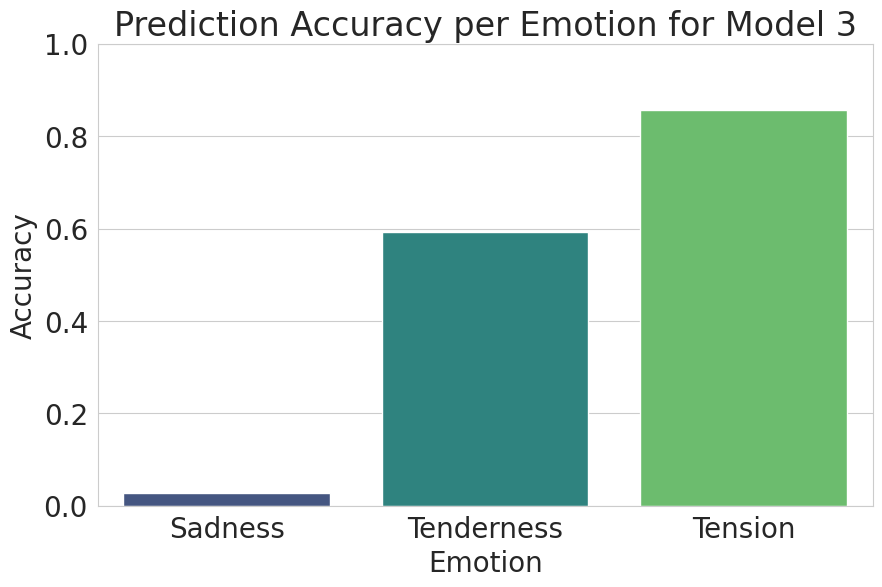

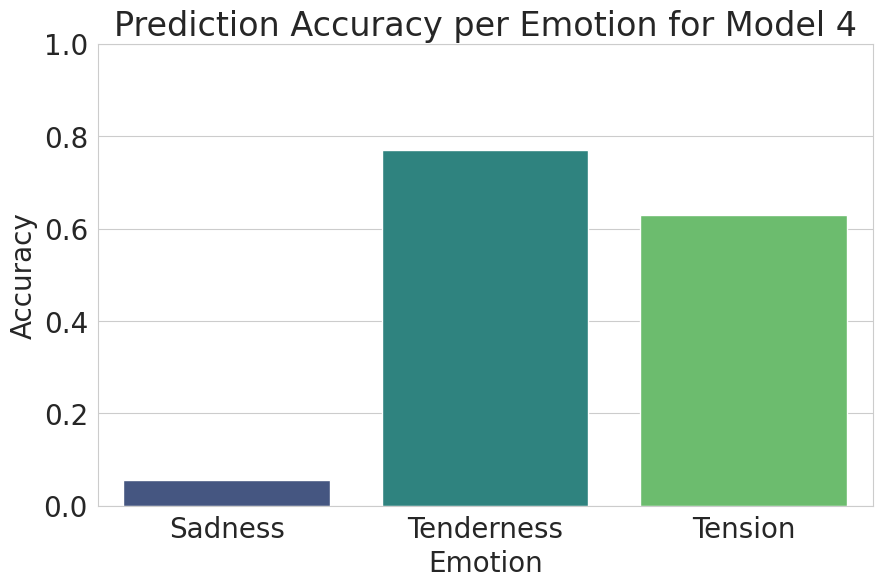

In [426]:
for i in range(len(models)):
  plot_accuracy(s_original_emotions,s_mapped_predictions[i],i+1)

### 4. Accuracy of the models

In [335]:
def plot_model_accuracy(accuracy, singleLabel=True):
  if singleLabel:
    title = 'Accuracy per model for Single Label Dataset'
  else:
    title = 'Accuracy per model for Multi Label Dataset'
  names = []
  for i in range(len(models)):
    names.append('Model ' + str(i+1))

  values = list(s_accuracy.values())

  plt.figure(figsize=(10, 5))
  plt.bar(range(len(s_accuracy)), values, tick_label=names)
  plt.title(title)
  plt.ylabel('Accuracy')
  plt.xlabel('Model')
  plt.rcParams.update({'font.size': 20})
  plt.show()

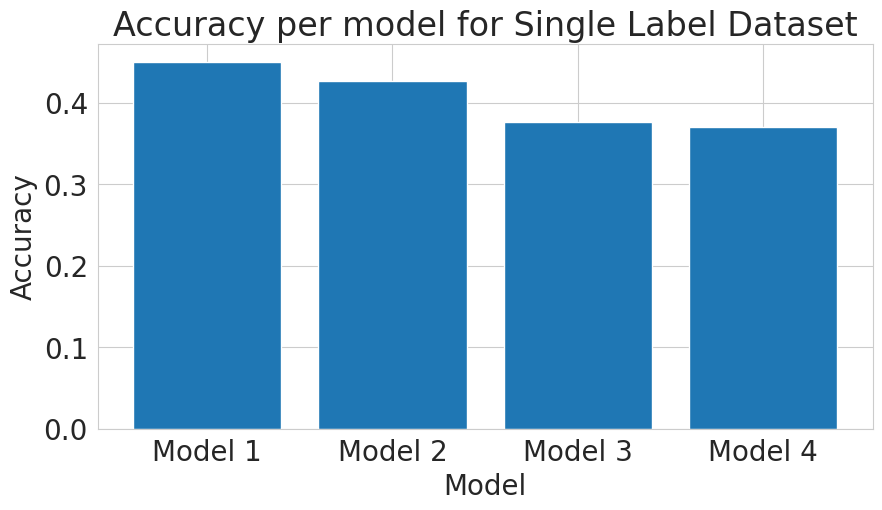

In [336]:
plot_model_accuracy(s_accuracy)

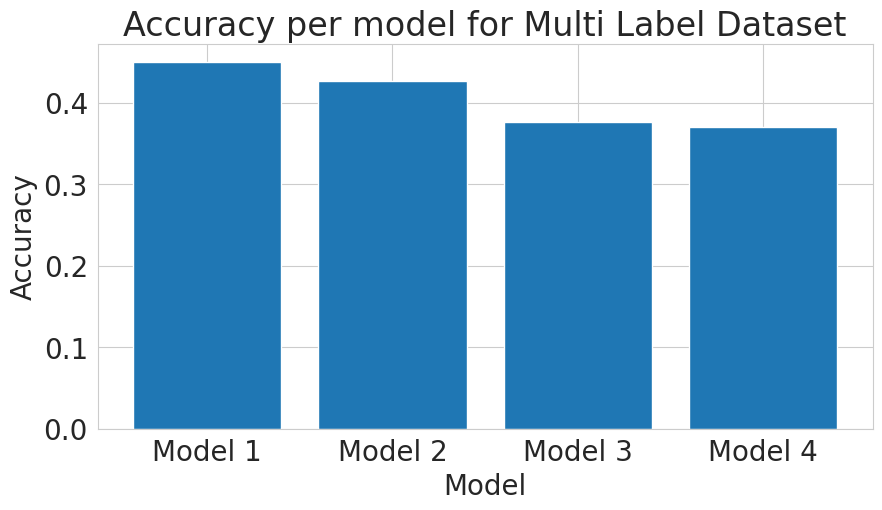

In [337]:
plot_model_accuracy(m_accuracy, singleLabel=False)

# Extra: Testing Model 1 on a Taylor Swift song

In [397]:
url = "https://raw.githubusercontent.com/glazar01/lyric-pulse-sentiment-analysis/main/data/TaylorSwift.csv"
taylor_songs = pd.read_csv(url)

In [398]:
taylor_songs.head()

,Unnamed: 0,Artist,Title,Album,Year,Date,Lyric
0,0,Taylor Swift,​cardigan,folklore,2020.0,2020-07-24,vintage tee brand new phone high heels on cobb...
1,1,Taylor Swift,​exile,folklore,2020.0,2020-07-24,justin vernon i can see you standing honey wit...
2,2,Taylor Swift,Lover,Lover,2019.0,2019-08-16,we could leave the christmas lights up 'til ja...
3,3,Taylor Swift,​the 1,folklore,2020.0,2020-07-24,i'm doing good i'm on some new shit been sayin...
4,4,Taylor Swift,Look What You Made Me Do,reputation,2017.0,2017-08-25,i don't like your little games don't like your...


In [403]:
song = taylor_songs.loc[35]
song

Unnamed: 0                                                   35
Artist                                             Taylor Swift
Title                                                Love Story
Album                                                  Fearless
Year                                                     2008.0
Date                                                 2008-09-12
Lyric         we were both young when i first saw you i clos...
Name: 35, dtype: object

In [404]:
lyrics = song['Lyric']

In [412]:
pred_emotion = {}

In [413]:
dom_emotion = {}

In [414]:
for i in range(len(models)-1):
  pred_emotion[i] = get_sentiment_scores_by_sentences(lyrics, models[i], model_emotions[i])

In [418]:
for index, emotions in pred_emotion.items():
    # Filter out 'neutral' and find the emotion with the highest score
    max_emotion = max(emotions, key=lambda k: emotions[k] if k != 'neutral' else -1)
    dom_emotion[index] = max_emotion

In [416]:
dom_emotion[3] = get_aggregated_emotion_for_lyrics(lyrics, models[3])

In [419]:
dom_emotion

{3: 'anger', 0: 'approval', 1: 'fear', 2: 'anger'}